Please upload your file (CSV or Excel).
Required columns: tc_id, us_id, tc_executiontime, us_businessvalue


Saving D1.xlsx to D1.xlsx
Successfully loaded 'D1.xlsx'


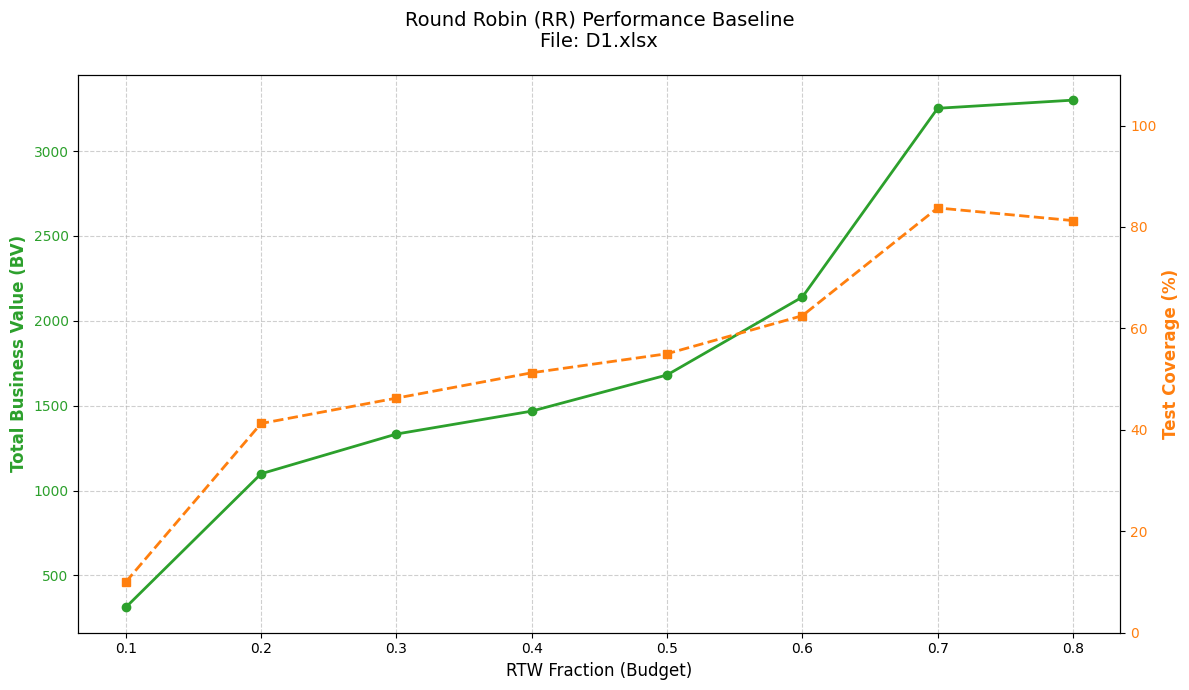

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
from typing import Dict, Any, Sequence
from google.colab import files

# --------------------------------------------------------------------
# 1. FILE UPLOAD & LOADING
# --------------------------------------------------------------------
print("Please upload your file (CSV or Excel).")
print("Required columns: tc_id, us_id, tc_executiontime, us_businessvalue")
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Please run the cell again.")
else:
    filename = list(uploaded.keys())[0]
    file_content = uploaded[filename]

    try:
        # Load the data based on file extension
        if filename.lower().endswith(('.xlsx', '.xls')):
            df_input = pd.read_excel(io.BytesIO(file_content))
        else:
            df_input = pd.read_csv(io.BytesIO(file_content), encoding='utf-8', errors='replace')

        print(f"Successfully loaded '{filename}'")

        # CONFIG: RTW_FRACTIONS
        RTW_FRACTIONS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

        # --------------------------------------------------------------------
        # 2. ROUND ROBIN MODEL BUILDING & ALGORITHM FUNCTIONS
        # --------------------------------------------------------------------
        def build_model_rr(df: pd.DataFrame) -> Dict[str, Any]:
            """Build model for RR-based SUKP selection."""
            test_ids = np.sort(df["tc_id"].unique())
            req_ids  = np.sort(df["us_id"].unique())
            n_tests, n_reqs = len(test_ids), len(req_ids)

            test_index = {tc_id: i for i, tc_id in enumerate(test_ids)}
            req_index  = {us_id: i for i, us_id in enumerate(req_ids)}

            test_et = np.zeros(n_tests, dtype=float)
            for tc in test_ids:
                test_et[test_index[tc]] = float(df.loc[df["tc_id"] == tc, "tc_executiontime"].iloc[0])

            req_bv = np.zeros(n_reqs, dtype=float)
            for us in req_ids:
                req_bv[req_index[us]] = float(df.loc[df["us_id"] == us, "us_businessvalue"].iloc[0])

            # many–many mapping: Requirement -> Tests
            req_to_tests_idx = [[] for _ in range(n_reqs)]
            for _, row in df.iterrows():
                ti, rj = test_index[row["tc_id"]], req_index[row["us_id"]]
                req_to_tests_idx[rj].append(ti)

            return {
                "test_ids": test_ids, "req_ids": req_ids, "test_et": test_et, "req_bv": req_bv,
                "req_to_tests_idx": [np.array(tidx, dtype=int) for tidx in req_to_tests_idx],
                "n_tests": n_tests, "n_reqs": n_reqs
            }

        def rr_sukp_single_rtw(model: Dict[str, Any], budget: float, start_req_index: int) -> Dict[str, Any]:
            """Single RTW selection using pure Round Robin over requirements."""
            n_tests, n_reqs = model["n_tests"], model["n_reqs"]
            test_et, req_bv = model["test_et"], model["req_bv"]
            req_to_tests_idx = model["req_to_tests_idx"]

            selected_tests = np.zeros(n_tests, dtype=bool)
            used_et = 0.0
            req_satisfied_rtw = np.zeros(n_reqs, dtype=bool)

            added_in_last_pass = True
            rr_head = start_req_index % n_reqs

            while added_in_last_pass:
                added_in_last_pass = False
                # One full cyclic pass starting from rr_head
                for offset in range(n_reqs):
                    rj = (rr_head + offset) % n_reqs
                    if req_satisfied_rtw[rj]: continue

                    tests_idx = req_to_tests_idx[rj]
                    if tests_idx.size == 0: continue

                    # Compute extra ET needed for this requirement's tests
                    extra_needed = 0.0
                    to_add = []
                    for ti in tests_idx:
                        if not selected_tests[ti]:
                            extra_needed += test_et[ti]
                            to_add.append(ti)

                    if extra_needed == 0.0:
                        req_satisfied_rtw[rj] = True
                        added_in_last_pass = True
                        continue

                    if used_et + extra_needed <= budget:
                        for ti in to_add:
                            selected_tests[ti] = True
                        used_et += extra_needed
                        req_satisfied_rtw[rj] = True
                        added_in_last_pass = True

                rr_head = (rr_head + 1) % n_reqs

            return {
                "total_bv": float(req_bv[req_satisfied_rtw].sum()),
                "test_coverage": 100.0 * float(selected_tests.sum()) / n_tests,
                "last_rr_index": rr_head
            }

        def rr_sukp_over_rtws(df: pd.DataFrame, rtw_fractions: Sequence[float]) -> Dict[float, Dict[str, Any]]:
            """Run Round Robin across multiple budget steps, maintaining head state."""
            model = build_model_rr(df)
            total_et = model["test_et"].sum()
            results = {}
            rr_head = 0  # Persistence across RTWs

            for frac in rtw_fractions:
                rtw_result = rr_sukp_single_rtw(model, float(frac) * total_et, rr_head)
                rr_head = rtw_result["last_rr_index"]
                results[float(frac)] = rtw_result
            return results

        # --------------------------------------------------------------------
        # 3. EXECUTION & PLOTTING
        # --------------------------------------------------------------------
        results = rr_sukp_over_rtws(df_input, RTW_FRACTIONS)

        fractions = sorted(results.keys())
        bv_values = [results[f]['total_bv'] for f in fractions]
        cvg_values = [results[f]['test_coverage'] for f in fractions]

        fig, ax1 = plt.subplots(figsize=(12, 7))

        # Plot BV (Primary Axis)
        color_bv = 'tab:green'
        ax1.set_xlabel('RTW Fraction (Budget)', fontsize=12)
        ax1.set_ylabel('Total Business Value (BV)', color=color_bv, fontweight='bold', fontsize=12)
        ax1.plot(fractions, bv_values, color=color_bv, marker='o', linewidth=2, label='BV')
        ax1.tick_params(axis='y', labelcolor=color_bv)
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Plot Test Coverage (Secondary Axis)
        ax2 = ax1.twinx()
        color_cvg = 'tab:orange'
        ax2.set_ylabel('Test Coverage (%)', color=color_cvg, fontweight='bold', fontsize=12)
        ax2.plot(fractions, cvg_values, color=color_cvg, marker='s', linestyle='--', linewidth=2, label='Test Coverage')
        ax2.tick_params(axis='y', labelcolor=color_cvg)
        ax2.set_ylim(0, 110)

        plt.title(f'Round Robin (RR) Performance Baseline\nFile: {filename}', fontsize=14, pad=20)
        fig.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing file: {e}")